#### In Gaussian process, we assume the mean is 0, so it's the covariance function we'll need to specify. <br>
##### A big advantage of Gaussian processes is that they can predict probabilistically - you can obtain confidence bounds on your  predictions.

##### A disadvantage - lack of efficiency in high-dimensional spaces

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston 
boston = load_boston()

boston_X = boston.data 
boston_y = boston.target 

train_set = np.random.choice([True, False],len(boston_y), p=[.75,.25])


###### Creating `GaussianProcessRegressor` object

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor 
gpr = GaussianProcessRegressor()
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

`alpha` is noise parameter <br> 
`kernel` The kernel to approximate a function. Default is `RBF` <br>
`normalize_y` can be set to true if the mean of the target set is not zero  <br>
`n_restart_optimizer` number of iteration to optimize the kernel. 10-20 can be good choice

In [3]:
#Creating a flexible kernel 

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK 

mixed_kernel = kernel = CK(1.0, (1e-4,1e4)) * RBF(10, (1e-4, 1e4))


In [4]:
#Instantiate and fitting the gaussian regressor 

gpr = GaussianProcessRegressor(alpha=5, n_restarts_optimizer=20, kernel=mixed_kernel)
gpr.fit(boston_X[train_set], boston_y[train_set])

GaussianProcessRegressor(alpha=5, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20)

In [5]:
test_preds = gpr.predict(boston_X[~train_set])

Text(0.5, 1.0, 'Histogram of Residuals')

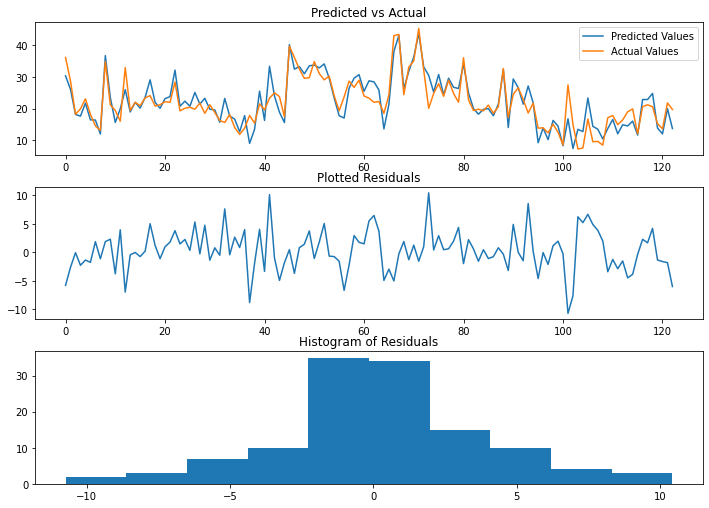

In [6]:
#Plotting 

from sklearn.model_selection import cross_val_predict 

from matplotlib import pyplot as plt 
%matplotlib inline 

fig, ax = plt.subplots(figsize=(10,7), nrows=3)
fig.tight_layout()

ax[0].plot(range(len(test_preds)), test_preds, label='Predicted Values')
ax[0].plot(range(len(test_preds)),boston_y[~train_set], label='Actual Values')
ax[0].set_title("Predicted vs Actual")
ax[0].legend(loc='best')

ax[1].plot(range(len(test_preds)), test_preds - boston_y[~train_set])
ax[1].set_title("Plotted Residuals")
ax[2].hist(test_preds - boston_y[~train_set])
ax[2].set_title("Histogram of Residuals")

To check if the best noise parameter is `alpha=5`, use cross-validation

In [7]:
from sklearn.model_selection import cross_val_score 

gpr5 = GaussianProcessRegressor(alpha=5, n_restarts_optimizer=20, kernel=mixed_kernel)
scores_5 = (cross_val_score(gpr5, boston_X[train_set],boston_y[train_set], cv=4, scoring='neg_mean_absolute_error'))

In [8]:
def score_mini_report(scores_list):
    print("List of Scores: ", scores_list)
    print("Mean of Scores: ",scores_list.mean())
    print("Standard Deviation of Scores: ", scores_list.std())

score_mini_report(scores_5)

List of Scores:  [ -4.04473033  -4.58450595  -3.98530049 -13.11553772]
Mean of Scores:  -6.432518625261151
Standard Deviation of Scores:  3.8654981757924243


In [9]:
#Now trying with alpha = 7 

gpr7 = GaussianProcessRegressor(alpha=7,
                                n_restarts_optimizer=20, kernel=mixed_kernel)
scores7 = (cross_val_score(gpr7, boston_X[train_set],boston_y[train_set], cv=4, scoring='neg_mean_absolute_error'))

In [10]:
score_mini_report(scores7)

List of Scores:  [ -3.38070429  -4.47139826  -4.02362043 -11.1847527 ]
Mean of Scores:  -5.765118919688613
Standard Deviation of Scores:  3.1529507430508903


In [11]:
#Again trying with alpha =7, and normalize_y=true

grp7n = GaussianProcessRegressor(alpha=7, n_restarts_optimizer=20,
                                 kernel=mixed_kernel, normalize_y=True)
scores7n = (cross_val_score(grp7n, boston_X[train_set],boston_y[train_set],cv=4,scoring='neg_mean_absolute_error'))

In [12]:
score_mini_report(scores7n)

List of Scores:  [ -6.02146305  -8.38822437  -7.02075776 -10.17098665]
Mean of Scores:  -7.900357958561441
Standard Deviation of Scores:  1.557057393086018


In [13]:
#Now lets select the last model for final training as the mean is higher and the standard deviation is lower among all 

grp7n.fit(boston_X[train_set],boston_y[train_set])

GaussianProcessRegressor(alpha=7, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

In [14]:
#Prediction 

test_prediction = grp7n.predict(boston_X[~train_set])


Text(0.5, 1.0, 'Histogram of Residuals')

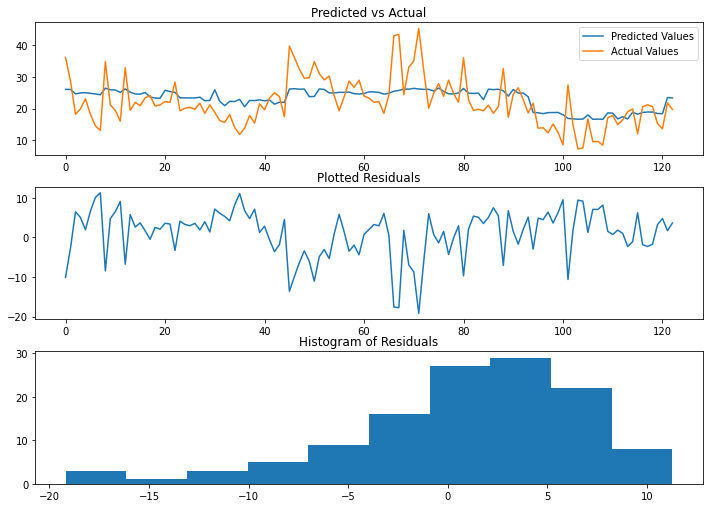

In [15]:
fig, ax = plt.subplots(figsize=(10,7), nrows=3)
fig.tight_layout()

ax[0].plot(range(len(test_prediction)), test_prediction, label='Predicted Values')
ax[0].plot(range(len(test_prediction)),boston_y[~train_set], label='Actual Values')
ax[0].set_title("Predicted vs Actual")
ax[0].legend(loc='best')

ax[1].plot(range(len(test_prediction)), test_prediction - boston_y[~train_set])
ax[1].set_title("Plotted Residuals")
ax[2].hist(test_prediction - boston_y[~train_set])
ax[2].set_title("Histogram of Residuals")

In [16]:
#We can get MSE and the predicted as follows: 

test_preds, MSE = grp7n.predict(boston_X[~train_set], return_std=True)
MSE[:5]

array([1.89404888, 1.89080849, 1.59545894, 1.56517017, 1.63364726])

(-1.0, 123.0)

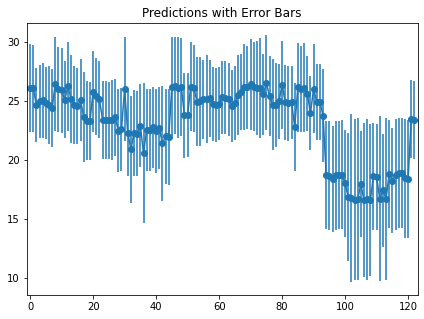

In [17]:
#Plotting the prediction with error bars as follows: 

f, ax = plt.subplots(figsize=(7, 5))
n = MSE.shape[0]
rng = range(n)
ax.scatter(rng, test_preds[:n])
ax.errorbar(rng, test_preds[:n], yerr=1.96*MSE[:n])
ax.set_title("Predictions with Error Bars")
ax.set_xlim((-1, n))

(-1.0, 40.0)

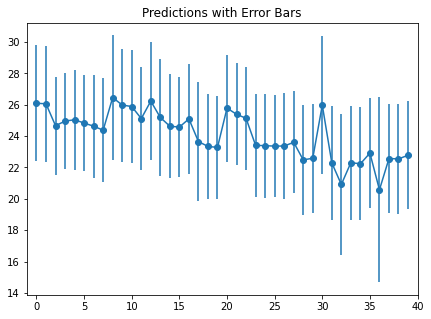

In [18]:
f, ax = plt.subplots(figsize=(7, 5))
n = 40
rng = range(n)
ax.scatter(rng, test_preds[:n])
ax.errorbar(rng, test_preds[:n], yerr=1.96*MSE[:n])
ax.set_title("Predictions with Error Bars")
ax.set_xlim((-1, n))

##### Trying `SGD` for Regression with large dataset

In [19]:
from sklearn.datasets import make_regression 
X, y = make_regression(int(1e6))

In [21]:
print("{:,}".format(X.nbytes))

800,000,000


In [24]:
from sklearn.linear_model import SGDRegressor 
sgd = SGDRegressor()
train = np.random.choice([True, False],size = len(y), p=[.75,.25])
sgd.fit(X[train],y[train])
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot:>

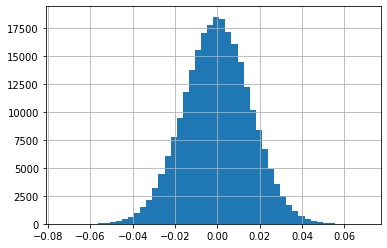

In [26]:
y_pred = sgd.predict(X[~train])
%matplotlib inline 
pd.Series(y[~train] - y_pred).hist(bins=50)